In [1]:
import numpy as np
from numpy import savetxt
from numpy import loadtxt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
import pickle 
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential, model_from_json
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from mpl_toolkits.axes_grid1 import make_axes_locatable
import corner

from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

import sys, platform, os
from numpy import sqrt, sin, cos, pi
import scipy.constants as cst

camb_path = os.path.realpath(os.path.join(os.getcwd(),'..'))
sys.path.insert(0,camb_path)
import camb
from camb import model, initialpower
tf.__version__

'2.8.0'

In [2]:
import scipy.integrate as integrate
import scipy.special as special     
from scipy.interpolate import CubicSpline
from scipy import interpolate
from scipy.optimize import curve_fit
from scipy.integrate import quad, dblquad

In [35]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.66, ombh2=0.02242, omch2=0.11933)
pars.InitPower.set_params(As=2.105209331e-9, ns=0.9665)
pars.set_matter_power(redshifts=[0.0], kmax=15.0)
pars.set_dark_energy(w=-1.0, wa=0, dark_energy_model='fluid')

# Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
camb_kh1, z, camb_pk_cur = results.get_matter_power_spectrum(minkh=1e-4, maxkh=15, npoints=100)
s8_current = np.array(results.get_sigma8())
s8_fid = np.array([0.8102])
renorm_s8 = (s8_fid/s8_current)**2
camb_pk1 = renorm_s8*camb_pk_cur

In [36]:
%%time 
bispectrum = []
counter = 0
K1 = []
K2 = []
K3 = []

for i in range(0, len(camb_kh1)):
    k1 = camb_kh1[i]
    for j in range(i, len(camb_kh1)):
        k2 = camb_kh1[j]
        for m in range(j, len(camb_kh1)):
            k3 = camb_kh1[m]

            if np.abs(k3) <= np.abs(k1) + np.abs(k2):                                        # Triangle inequality
                
                K1.append(k1)
                K2.append(k2)
                K3.append(k3)
                
                c_theta12 = (k1**2 + k2**2 - k3**2)/2*k1*k2
                c_theta23 = (k2**2 + k3**2 - k1**2)/2*k2*k3
                c_theta31 = (k3**2 + k1**2 - k2**2)/2*k3*k1
            
                k12_dot = np.abs(k1*k2)*c_theta12
                k23_dot = np.abs(k2*k3)*c_theta23
                k31_dot = np.abs(k3*k1)*c_theta31
            
                bp = (10/7 + (k12_dot/k1*k2)*(k1/k2 + k2/k1) + 4/7*(k12_dot/k1*k2)**2)*camb_pk1[0][i]*camb_pk1[0][j] \
                + (10/7 + (k23_dot/k2*k3)*(k2/k3 + k3/k2) + 4/7*(k23_dot/k2*k3)**2)*camb_pk1[0][j]*camb_pk1[0][m] \
                + (10/7 + (k31_dot/k3*k1)*(k3/k1 + k1/k3) + 4/7*(k31_dot/k3*k1)**2)*camb_pk1[0][m]*camb_pk1[0][i]

                bispectrum.append(bp)
                #print('bispectrum:', bp)
                
                counter += 1
                print('counter:', counter)
                

print('bispectrum shape:', np.shape(bispectrum))
print('K1:', np.shape(K1))
print('K2:', np.shape(K2))
print('K3:', np.shape(K3))

counter: 1
counter: 2
counter: 3
counter: 4
counter: 5
counter: 6
counter: 7
counter: 8
counter: 9
counter: 10
counter: 11
counter: 12
counter: 13
counter: 14
counter: 15
counter: 16
counter: 17
counter: 18
counter: 19
counter: 20
counter: 21
counter: 22
counter: 23
counter: 24
counter: 25
counter: 26
counter: 27
counter: 28
counter: 29
counter: 30
counter: 31
counter: 32
counter: 33
counter: 34
counter: 35
counter: 36
counter: 37
counter: 38
counter: 39
counter: 40
counter: 41
counter: 42
counter: 43
counter: 44
counter: 45
counter: 46
counter: 47
counter: 48
counter: 49
counter: 50
counter: 51
counter: 52
counter: 53
counter: 54
counter: 55
counter: 56
counter: 57
counter: 58
counter: 59
counter: 60
counter: 61
counter: 62
counter: 63
counter: 64
counter: 65
counter: 66
counter: 67
counter: 68
counter: 69
counter: 70
counter: 71
counter: 72
counter: 73
counter: 74
counter: 75
counter: 76
counter: 77
counter: 78
counter: 79
counter: 80
counter: 81
counter: 82
counter: 83
counter: 84
c

counter: 669
counter: 670
counter: 671
counter: 672
counter: 673
counter: 674
counter: 675
counter: 676
counter: 677
counter: 678
counter: 679
counter: 680
counter: 681
counter: 682
counter: 683
counter: 684
counter: 685
counter: 686
counter: 687
counter: 688
counter: 689
counter: 690
counter: 691
counter: 692
counter: 693
counter: 694
counter: 695
counter: 696
counter: 697
counter: 698
counter: 699
counter: 700
counter: 701
counter: 702
counter: 703
counter: 704
counter: 705
counter: 706
counter: 707
counter: 708
counter: 709
counter: 710
counter: 711
counter: 712
counter: 713
counter: 714
counter: 715
counter: 716
counter: 717
counter: 718
counter: 719
counter: 720
counter: 721
counter: 722
counter: 723
counter: 724
counter: 725
counter: 726
counter: 727
counter: 728
counter: 729
counter: 730
counter: 731
counter: 732
counter: 733
counter: 734
counter: 735
counter: 736
counter: 737
counter: 738
counter: 739
counter: 740
counter: 741
counter: 742
counter: 743
counter: 744
counter: 745

counter: 1419
counter: 1420
counter: 1421
counter: 1422
counter: 1423
counter: 1424
counter: 1425
counter: 1426
counter: 1427
counter: 1428
counter: 1429
counter: 1430
counter: 1431
counter: 1432
counter: 1433
counter: 1434
counter: 1435
counter: 1436
counter: 1437
counter: 1438
counter: 1439
counter: 1440
counter: 1441
counter: 1442
counter: 1443
counter: 1444
counter: 1445
counter: 1446
counter: 1447
counter: 1448
counter: 1449
counter: 1450
counter: 1451
counter: 1452
counter: 1453
counter: 1454
counter: 1455
counter: 1456
counter: 1457
counter: 1458
counter: 1459
counter: 1460
counter: 1461
counter: 1462
counter: 1463
counter: 1464
counter: 1465
counter: 1466
counter: 1467
counter: 1468
counter: 1469
counter: 1470
counter: 1471
counter: 1472
counter: 1473
counter: 1474
counter: 1475
counter: 1476
counter: 1477
counter: 1478
counter: 1479
counter: 1480
counter: 1481
counter: 1482
counter: 1483
counter: 1484
counter: 1485
counter: 1486
counter: 1487
counter: 1488
counter: 1489
counte

counter: 2169
counter: 2170
counter: 2171
counter: 2172
counter: 2173
counter: 2174
counter: 2175
counter: 2176
counter: 2177
counter: 2178
counter: 2179
counter: 2180
counter: 2181
counter: 2182
counter: 2183
counter: 2184
counter: 2185
counter: 2186
counter: 2187
counter: 2188
counter: 2189
counter: 2190
counter: 2191
counter: 2192
counter: 2193
counter: 2194
counter: 2195
counter: 2196
counter: 2197
counter: 2198
counter: 2199
counter: 2200
counter: 2201
counter: 2202
counter: 2203
counter: 2204
counter: 2205
counter: 2206
counter: 2207
counter: 2208
counter: 2209
counter: 2210
counter: 2211
counter: 2212
counter: 2213
counter: 2214
counter: 2215
counter: 2216
counter: 2217
counter: 2218
counter: 2219
counter: 2220
counter: 2221
counter: 2222
counter: 2223
counter: 2224
counter: 2225
counter: 2226
counter: 2227
counter: 2228
counter: 2229
counter: 2230
counter: 2231
counter: 2232
counter: 2233
counter: 2234
counter: 2235
counter: 2236
counter: 2237
counter: 2238
counter: 2239
counte

counter: 2954
counter: 2955
counter: 2956
counter: 2957
counter: 2958
counter: 2959
counter: 2960
counter: 2961
counter: 2962
counter: 2963
counter: 2964
counter: 2965
counter: 2966
counter: 2967
counter: 2968
counter: 2969
counter: 2970
counter: 2971
counter: 2972
counter: 2973
counter: 2974
counter: 2975
counter: 2976
counter: 2977
counter: 2978
counter: 2979
counter: 2980
counter: 2981
counter: 2982
counter: 2983
counter: 2984
counter: 2985
counter: 2986
counter: 2987
counter: 2988
counter: 2989
counter: 2990
counter: 2991
counter: 2992
counter: 2993
counter: 2994
counter: 2995
counter: 2996
counter: 2997
counter: 2998
counter: 2999
counter: 3000
counter: 3001
counter: 3002
counter: 3003
counter: 3004
counter: 3005
counter: 3006
counter: 3007
counter: 3008
counter: 3009
counter: 3010
counter: 3011
counter: 3012
counter: 3013
counter: 3014
counter: 3015
counter: 3016
counter: 3017
counter: 3018
counter: 3019
counter: 3020
counter: 3021
counter: 3022
counter: 3023
counter: 3024
counte

counter: 3791
counter: 3792
counter: 3793
counter: 3794
counter: 3795
counter: 3796
counter: 3797
counter: 3798
counter: 3799
counter: 3800
counter: 3801
counter: 3802
counter: 3803
counter: 3804
counter: 3805
counter: 3806
counter: 3807
counter: 3808
counter: 3809
counter: 3810
counter: 3811
counter: 3812
counter: 3813
counter: 3814
counter: 3815
counter: 3816
counter: 3817
counter: 3818
counter: 3819
counter: 3820
counter: 3821
counter: 3822
counter: 3823
counter: 3824
counter: 3825
counter: 3826
counter: 3827
counter: 3828
counter: 3829
counter: 3830
counter: 3831
counter: 3832
counter: 3833
counter: 3834
counter: 3835
counter: 3836
counter: 3837
counter: 3838
counter: 3839
counter: 3840
counter: 3841
counter: 3842
counter: 3843
counter: 3844
counter: 3845
counter: 3846
counter: 3847
counter: 3848
counter: 3849
counter: 3850
counter: 3851
counter: 3852
counter: 3853
counter: 3854
counter: 3855
counter: 3856
counter: 3857
counter: 3858
counter: 3859
counter: 3860
counter: 3861
counte

counter: 4622
counter: 4623
counter: 4624
counter: 4625
counter: 4626
counter: 4627
counter: 4628
counter: 4629
counter: 4630
counter: 4631
counter: 4632
counter: 4633
counter: 4634
counter: 4635
counter: 4636
counter: 4637
counter: 4638
counter: 4639
counter: 4640
counter: 4641
counter: 4642
counter: 4643
counter: 4644
counter: 4645
counter: 4646
counter: 4647
counter: 4648
counter: 4649
counter: 4650
counter: 4651
counter: 4652
counter: 4653
counter: 4654
counter: 4655
counter: 4656
counter: 4657
counter: 4658
counter: 4659
counter: 4660
counter: 4661
counter: 4662
counter: 4663
counter: 4664
counter: 4665
counter: 4666
counter: 4667
counter: 4668
counter: 4669
counter: 4670
counter: 4671
counter: 4672
counter: 4673
counter: 4674
counter: 4675
counter: 4676
counter: 4677
counter: 4678
counter: 4679
counter: 4680
counter: 4681
counter: 4682
counter: 4683
counter: 4684
counter: 4685
counter: 4686
counter: 4687
counter: 4688
counter: 4689
counter: 4690
counter: 4691
counter: 4692
counte

counter: 5464
counter: 5465
counter: 5466
counter: 5467
counter: 5468
counter: 5469
counter: 5470
counter: 5471
counter: 5472
counter: 5473
counter: 5474
counter: 5475
counter: 5476
counter: 5477
counter: 5478
counter: 5479
counter: 5480
counter: 5481
counter: 5482
counter: 5483
counter: 5484
counter: 5485
counter: 5486
counter: 5487
counter: 5488
counter: 5489
counter: 5490
counter: 5491
counter: 5492
counter: 5493
counter: 5494
counter: 5495
counter: 5496
counter: 5497
counter: 5498
counter: 5499
counter: 5500
counter: 5501
counter: 5502
counter: 5503
counter: 5504
counter: 5505
counter: 5506
counter: 5507
counter: 5508
counter: 5509
counter: 5510
counter: 5511
counter: 5512
counter: 5513
counter: 5514
counter: 5515
counter: 5516
counter: 5517
counter: 5518
counter: 5519
counter: 5520
counter: 5521
counter: 5522
counter: 5523
counter: 5524
counter: 5525
counter: 5526
counter: 5527
counter: 5528
counter: 5529
counter: 5530
counter: 5531
counter: 5532
counter: 5533
counter: 5534
counte

counter: 6417
counter: 6418
counter: 6419
counter: 6420
counter: 6421
counter: 6422
counter: 6423
counter: 6424
counter: 6425
counter: 6426
counter: 6427
counter: 6428
counter: 6429
counter: 6430
counter: 6431
counter: 6432
counter: 6433
counter: 6434
counter: 6435
counter: 6436
counter: 6437
counter: 6438
counter: 6439
counter: 6440
counter: 6441
counter: 6442
counter: 6443
counter: 6444
counter: 6445
counter: 6446
counter: 6447
counter: 6448
counter: 6449
counter: 6450
counter: 6451
counter: 6452
counter: 6453
counter: 6454
counter: 6455
counter: 6456
counter: 6457
counter: 6458
counter: 6459
counter: 6460
counter: 6461
counter: 6462
counter: 6463
counter: 6464
counter: 6465
counter: 6466
counter: 6467
counter: 6468
counter: 6469
counter: 6470
counter: 6471
counter: 6472
counter: 6473
counter: 6474
counter: 6475
counter: 6476
counter: 6477
counter: 6478
counter: 6479
counter: 6480
counter: 6481
counter: 6482
counter: 6483
counter: 6484
counter: 6485
counter: 6486
counter: 6487
counte

counter: 7542
counter: 7543
counter: 7544
counter: 7545
counter: 7546
counter: 7547
counter: 7548
counter: 7549
counter: 7550
counter: 7551
counter: 7552
counter: 7553
counter: 7554
counter: 7555
counter: 7556
counter: 7557
counter: 7558
counter: 7559
counter: 7560
counter: 7561
counter: 7562
counter: 7563
counter: 7564
counter: 7565
counter: 7566
counter: 7567
counter: 7568
counter: 7569
counter: 7570
counter: 7571
counter: 7572
counter: 7573
counter: 7574
counter: 7575
counter: 7576
counter: 7577
counter: 7578
counter: 7579
counter: 7580
counter: 7581
counter: 7582
counter: 7583
counter: 7584
counter: 7585
counter: 7586
counter: 7587
counter: 7588
counter: 7589
counter: 7590
counter: 7591
counter: 7592
counter: 7593
counter: 7594
counter: 7595
counter: 7596
counter: 7597
counter: 7598
counter: 7599
counter: 7600
counter: 7601
counter: 7602
counter: 7603
counter: 7604
counter: 7605
counter: 7606
counter: 7607
counter: 7608
counter: 7609
counter: 7610
counter: 7611
counter: 7612
counte

counter: 8578
counter: 8579
counter: 8580
counter: 8581
counter: 8582
counter: 8583
counter: 8584
counter: 8585
counter: 8586
counter: 8587
counter: 8588
counter: 8589
counter: 8590
counter: 8591
counter: 8592
counter: 8593
counter: 8594
counter: 8595
counter: 8596
counter: 8597
counter: 8598
counter: 8599
counter: 8600
counter: 8601
counter: 8602
counter: 8603
counter: 8604
counter: 8605
counter: 8606
counter: 8607
counter: 8608
counter: 8609
counter: 8610
counter: 8611
counter: 8612
counter: 8613
counter: 8614
counter: 8615
counter: 8616
counter: 8617
counter: 8618
counter: 8619
counter: 8620
counter: 8621
counter: 8622
counter: 8623
counter: 8624
counter: 8625
counter: 8626
counter: 8627
counter: 8628
counter: 8629
counter: 8630
counter: 8631
counter: 8632
counter: 8633
counter: 8634
counter: 8635
counter: 8636
counter: 8637
counter: 8638
counter: 8639
counter: 8640
counter: 8641
counter: 8642
counter: 8643
counter: 8644
counter: 8645
counter: 8646
counter: 8647
counter: 8648
counte

In [37]:
print(np.shape(bispectrum))

(8927,)


In [51]:
print(bispectrum[4])
print(bispectrum[5])
print(bispectrum[6])
print(bispectrum[7])
print(bispectrum[8])
print(bispectrum[9])
print(bispectrum[10])
print(bispectrum[-1])

1089465.435317555
1191613.9561028662
913540.1868512505
990117.0891306081
1076118.8994212002
1172698.2233243862
1281145.3244583225
323410712704.7617


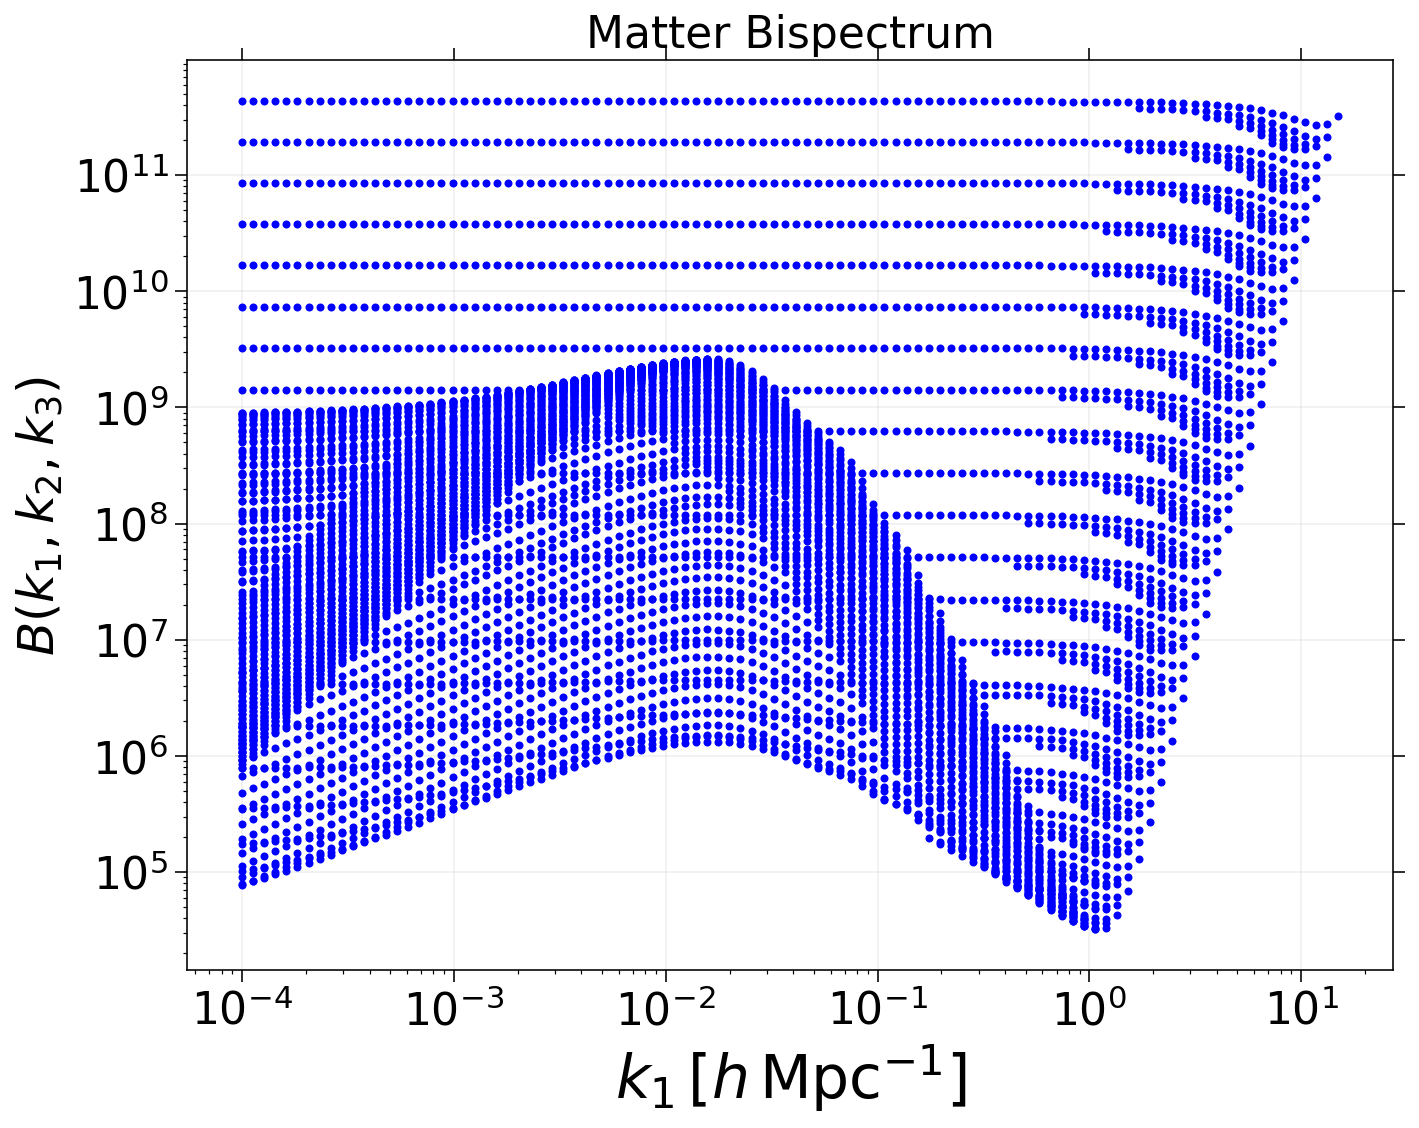

In [56]:
plt.figure(figsize = (10,8))
plt.loglog(K1, bispectrum, 'b.') 
#plt.loglog(K2, bispectrum, 'r.')
#plt.loglog(K3, bispectrum, 'g.') 
#plt.yscale('linear')

plt.title('Matter Bispectrum', fontsize = 22)
plt.rc('axes', labelsize=22)
plt.rc('axes', titlesize=22)
plt.rcParams['xtick.labelsize']=22
plt.rcParams['ytick.labelsize']=22
plt.xlabel(r'$k_{1}\,[h\,\mathrm{Mpc}^{-1}]$', fontsize=30)
plt.ylabel(r'$B(k_{1},k_{2},k_{3})$', fontsize=25)
#plt.legend(["Linear", "Non-linear"], loc='upper right', fontsize=22);
plt.grid(alpha=0.2)
plt.tick_params(top=True,right=True, length=6)

plt.tight_layout()
#plt.savefig('NLMPS_1dim_H0_MaxPE_comb.pdf')
plt.show()

In [ ]:
def bispectrum(k1, k2, k3):

    return (10/7 + (np.dot(k1,k2)/k1*k2)*(k1/k2 + k2/k1) + 4/7*(np.dot(k1,k2)/k1*k2)**2)*camb_pk1*camb_pk2 \
         + (10/7 + (np.dot(k2,k3)/k2*k3)*(k2/k3 + k3/k2) + 4/7*(np.dot(k2,k3)/k2*k3)**2)*camb_pk2*camb_pk3 \
         + (10/7 + (np.dot(k3,k1)/k3*k1)*(k3/k1 + k1/k3) + 4/7*(np.dot(k3,k1)/k3*k1)**2)*camb_pk3*camb_pk1